In [ ]:
import torch as T
import triton
import triton.language as tl
from triton.compiler import ASTSource, compile as triton_compile
from typing import Optional

In [ ]:
T.backends.cudnn.benchmark = True  # enable cudnn auto-tuner
T.backends.cuda.matmul.allow_tf32 = True  # allow TF32 on matmul
T.backends.cudnn.allow_tf32 = True  # allow TF32 on cudnn

In [11]:
T.manual_seed(1773)
DEVICE = T.device("cuda" if T.cuda.is_available() else "cpu")

In [ ]:
# DEVICE = triton.runtime.driver.active.get_active_torch_device()
def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"

def is_hip_cdna2():
    target = triton.runtime.driver.active.get_current_target()
    return target.backend == 'hip' and target.arch == 'gfx90a'

In [7]:
def get_cuda_autotune_config() -> list[triton.Config]:
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, \
            'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages = 3, num_warps = 8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, \
            'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, \
            'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, \
            'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, \
            'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, \
            'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, \
            'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages = 5, num_warps = 2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, \
            'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages = 5, num_warps = 2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, \
            'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages = 3, num_warps = 8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, \
            'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages = 3, num_warps = 8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, \
            'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, \
            'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, \
            'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, \
            'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, \
            'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, \
            'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages = 4, num_warps = 4)
    ]


def get_hip_autotune_config() -> list[triton.Config]:
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, \
                'GROUP_SIZE_M': 1, 'waves_per_eu': 2}, num_warps = 4, num_stages = 2),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, \
            'GROUP_SIZE_M': 4, 'waves_per_eu': 2}, num_warps = 8, num_stages = 2),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, \
            'GROUP_SIZE_M': 1, 'waves_per_eu': 2}, num_warps = 8, num_stages = 2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, \
            'GROUP_SIZE_M': 8, 'waves_per_eu': 3}, num_warps = 4, num_stages = 2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, \
            'GROUP_SIZE_M': 1, 'waves_per_eu': 8}, num_warps = 4, num_stages = 2),
    ]


def get_autotune_config():
    if is_cuda(): return get_cuda_autotune_config()
    else: return get_hip_autotune_config()

In [17]:
@triton.autotune(configs = get_autotune_config(), key = ['M', 'N', 'K'])
@triton.jit
def matmul_kernel(a_ptr, b_ptr, c_ptr, M, N, K, stride_a_m, stride_a_k, \
    stride_b_k, stride_b_n, stride_c_m, stride_c_n, BLOCK_SIZE_M: tl.constexpr, \
        BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  \
            GROUP_SIZE_M: tl.constexpr, ACTIVATION: tl.constexpr) -> None:
    # map `pid` to the block of C it should compute
    # done in a grouped ordering to promote L2 data reuse
    pid = tl.program_id(axis = 0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offset_a_m = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offset_b_n = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offset_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offset_a_m[:, None] * stride_a_m + offset_k[None, :] * stride_a_k)
    b_ptrs = b_ptr + (offset_k[:, None] * stride_b_k + offset_b_n[None, :] * stride_b_n)
    # accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block of fp32 values for higher accuracy
    # `accumulator` converted back to fp16 after loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype = tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # load next block of A and B, generate mask by checking K dimension
        # if its out of bounds, set it to 0
        a = tl.load(a_ptrs, mask = offset_k[None, :] < K - k * BLOCK_SIZE_K, other = 0.0)
        b = tl.load(b_ptrs, mask = offset_k[:, None] < K - k * BLOCK_SIZE_K, other = 0.0)
        # accumulate along K dimension
        accumulator = tl.dot(a, b, accumulator)
        # Advance ptrs to next K block
        a_ptrs += BLOCK_SIZE_K * stride_a_k
        b_ptrs += BLOCK_SIZE_K * stride_b_k
    # can fuse arbitrary activation functions while accumulator is still in FP32
    if ACTIVATION == "leaky_relu": accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)
    # write back block of output matrix C with masks
    offset_c_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offset_c_n = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_c_m * offset_c_m[:, None] + stride_c_n * offset_c_n[None, :]
    c_mask = (offset_c_m[:, None] < M) & (offset_c_n[None, :] < N)
    tl.store(c_ptrs, c, mask = c_mask)

@triton.jit
def leaky_relu(x): return tl.where(x >= 0, x, 0.01 * x)

In [18]:
def matmul(a: T.Tensor, b: T.Tensor, activation: Optional[str] = "") -> T.Tensor:
    assert a.shape[1] == b.shape[0], "incompatible dimensions"
    assert a.is_contiguous(), "matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    c: T.Tensor = T.empty((M, N), device = a.device, dtype = T.float16)
    # launch kernel
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * \
        triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](a, b, c, M, N, K, a.stride(0), a.stride(1), \
        b.stride(0), b.stride(1), c.stride(0), c.stride(1), ACTIVATION = activation)
    return c

In [ ]:
a: T.Tensor = T.randn((512, 512), device = DEVICE, dtype = T.float16)
b: T.Tensor = T.randn((512, 512), device = DEVICE, dtype = T.float16)
triton_output = matmul(a, b)
torch_output = T.matmul(a, b)
print(f"triton_output_with_fp16_inputs = {triton_output}")
print(f"torch_output_with_fp16_inputs = {torch_output}")
rtol = 1e-2 if is_hip_cdna2() else 0
if T.allclose(triton_output, torch_output, atol = 1e-2, rtol = rtol): \
    print("✅ Triton and Torch match")
else: print("❌ Triton and Torch differ")

TORCH_HAS_FP8: Optional[bool] = hasattr(T, "float8_e5m2")
if TORCH_HAS_FP8 and is_cuda():
    T.manual_seed(0)
    a = T.randn((512, 512), device = DEVICE, dtype = T.float16)
    b = T.randn((512, 512), device = DEVICE, dtype = T.float16)
    a = a.to(T.float8_e5m2)
    # pre-transpose b for efficiency.
    b = b.T
    b = b.to(T.float8_e5m2)
    triton_output = matmul(a, b)
    torch_output = T.matmul(a.to(T.float16), b.to(T.float16))
    print(f"triton_output_with_fp8_inputs = {triton_output}")
    print(f"torch_output_with_fp8_inputs = {torch_output}")
    if T.allclose(triton_output, torch_output, atol = 0.125, rtol = 0):
        print("✅ Triton and Torch match")
    else: print("❌ Triton and Torch differ")

triton_output_with_fp16_inputs=tensor([[-37.0000,  42.8125,  -1.1387,  ..., -11.6328,   3.5801,   1.5244],
        [-59.3438,  13.1328, -19.6562,  ...,  40.6875,  -1.3262,  -6.3359],
        [ -5.3164,  29.3438,  -7.4688,  ...,  -9.0781,   0.5073,  -9.9453],
        ...,
        [  3.8340, -42.1250,   9.0312,  ...,  -9.1250, -15.0781,  12.0469],
        [-39.9688,  20.4062,  10.9531,  ...,  24.6875,   0.4851, -31.5156],
        [  2.5273, -16.2656,  11.3359,  ...,  -3.9512, -20.1875,  12.8125]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[-37.0000,  42.8125,  -1.1387,  ..., -11.6328,   3.5801,   1.5244],
        [-59.3438,  13.1328, -19.6562,  ...,  40.6875,  -1.3262,  -6.3359],
        [ -5.3164,  29.3438,  -7.4688,  ...,  -9.0781,   0.5073,  -9.9453],
        ...,
        [  3.8340, -42.1250,   9.0312,  ...,  -9.1250, -15.0781,  12.0469],
        [-39.9688,  20.4062,  10.9531,  ...,  24.6875,   0.4851, -31.5156],
        [  2.5273, -16.2656,  1

In [ ]:
ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'
configs = []
for fp8_inputs in [False, True]:
    if fp8_inputs and (not TORCH_HAS_FP8 or not is_cuda()):
        continue
    configs.append(
        triton.testing.Benchmark(
            x_names = ["M", "N", "K"], 
            x_vals = [128 * i for i in range(2, 33)],
            line_arg = "provider",  
            line_vals = ["triton"] if fp8_inputs else [ref_lib.lower(), "triton"], 
            line_names = ["Triton"] if fp8_inputs else [ref_lib, "Triton"],
            styles = [("green", "-"), ("blue", "-")],
            ylabel = "TFLOPS",  
            plot_name = "matmul-performance-" +
            ("fp16" if not fp8_inputs else "fp8"), 
            args = {"fp8_inputs": fp8_inputs},
        ))

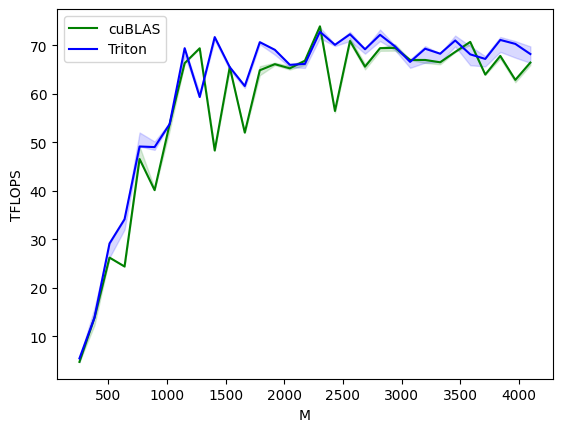

matmul-performance-fp16:
         M       N       K     cuBLAS     Triton
0    256.0   256.0   256.0   4.681143   5.405031
1    384.0   384.0   384.0  13.824000  13.824000
2    512.0   512.0   512.0  26.214401  29.127110
3    640.0   640.0   640.0  24.380953  34.133334
4    768.0   768.0   768.0  46.565055  49.151998
5    896.0   896.0   896.0  40.140799  49.026931
6   1024.0  1024.0  1024.0  53.773130  53.773130
7   1152.0  1152.0  1152.0  66.355199  69.441488
8   1280.0  1280.0  1280.0  69.423727  59.362318
9   1408.0  1408.0  1408.0  48.325992  71.733898
10  1536.0  1536.0  1536.0  65.536000  65.536000
11  1664.0  1664.0  1664.0  52.016834  61.636381
12  1792.0  1792.0  1792.0  64.885723  70.688200
13  1920.0  1920.0  1920.0  66.143539  69.109201
14  2048.0  2048.0  2048.0  65.280994  66.011426
15  2176.0  2176.0  2176.0  66.855975  66.196213
16  2304.0  2304.0  2304.0  73.956263  72.828879
17  2432.0  2432.0  2432.0  56.476603  70.137528
18  2560.0  2560.0  2560.0  70.926407  72.31

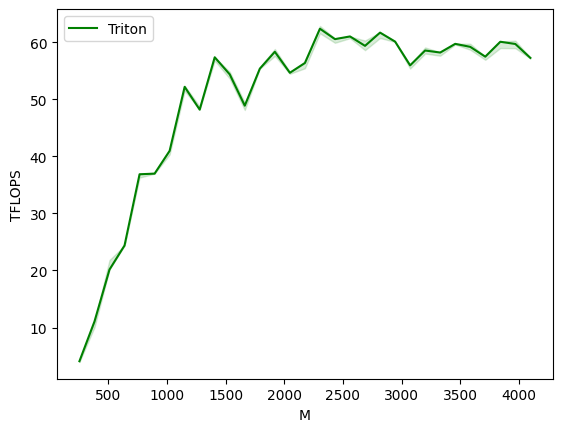

matmul-performance-fp8:
         M       N       K     Triton
0    256.0   256.0   256.0   4.096000
1    384.0   384.0   384.0  11.059200
2    512.0   512.0   512.0  20.164923
3    640.0   640.0   640.0  24.380953
4    768.0   768.0   768.0  36.863999
5    896.0   896.0   896.0  36.971791
6   1024.0  1024.0  1024.0  40.970002
7   1152.0  1152.0  1152.0  52.185412
8   1280.0  1280.0  1280.0  48.188235
9   1408.0  1408.0  1408.0  57.368243
10  1536.0  1536.0  1536.0  54.366878
11  1664.0  1664.0  1664.0  48.882225
12  1792.0  1792.0  1792.0  55.366620
13  1920.0  1920.0  1920.0  58.329114
14  2048.0  2048.0  2048.0  54.648910
15  2176.0  2176.0  2176.0  56.368760
16  2304.0  2304.0  2304.0  62.370422
17  2432.0  2432.0  2432.0  60.548412
18  2560.0  2560.0  2560.0  61.020483
19  2688.0  2688.0  2688.0  59.368960
20  2816.0  2816.0  2816.0  61.689118
21  2944.0  2944.0  2944.0  60.115839
22  3072.0  3072.0  3072.0  55.951683
23  3200.0  3200.0  3200.0  58.554434
24  3328.0  3328.0  3328.0

In [ ]:
@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a: T.Tensor = T.randn((M, K), device = DEVICE, dtype = T.float16)
    b: T.Tensor = T.randn((K, N), device = DEVICE, dtype = T.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(T.float8_e5m2)
        b = b.T
        b = b.to(T.float8_e5m2)
    quantiles: list[float] = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: \
            T.matmul(a, b), quantiles = quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: \
            matmul(a, b), quantiles = quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots = True, print_data = True)